In [1]:
import sys
from google.cloud import bigquery
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, average_precision_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve, confusion_matrix
import pickle

/opt/conda/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# %pip install --upgrade google-cloud-bigquery google-cloud-bigquery-storage pandas-gbq
# %pip install --upgrade seaborn datetime matplotlib pandas numpy shap xgboost scikit-learn

In [2]:
%%time

client = bigquery.Client(project = 'etsy-bigquery-adhoc-prod')

query = '''

SELECT b.* except(listing_taxonomy_full_path, 
    rec_added_to_cart, rec_favorited,
    rec_purchased_after_view,
    visit_items_purchased, visit_total_gms, 
    l0_cat_2, l0_cat_3,
    visit_cart_adds, visit_bounced, 
    visit_pages_seen,
    user_id, visit_id, listing_id, 
    shop_id, seller_id,         
    recs_engaged_click_proxy) 
FROM    `etsy-data-warehouse-dev.tsebastian.mule_sq_1pct_bound_reset` b
WHERE variant_id != 'mule_sq_50'
'''

print("Starting BigQuery job...")
query_job = client.query(query)

df = query_job.result().to_dataframe(create_bqstorage_client=True)
print(f"Dataframe loaded: {len(df):,} rows.")
df.head()

Starting BigQuery job...
Dataframe loaded: 37,339,621 rows.
CPU times: user 4min 7s, sys: 3min 41s, total: 7min 49s
Wall time: 1min 59s


,_date,variant_id,candidate_set,sequence_number,visit_referring_domain,visit_canonical_region,event_source,visit_channel,rec_seen,rec_price,...,home_cart_adds_7,qis_broad_90d,qis_direct_unspecified_90d,qis_direct_specified_90d,qis_broad_30d,qis_direct_unspecified_30d,qis_direct_specified_30d,qis_broad_7d,qis_direct_unspecified_7d,qis_direct_specified_7d
0,2025-11-12,mule_sq_100,arizona:MULE_SQ_v0_4_3_lf7_dyn_k_Blend,121,etsy,GB,android,internal,0,0.9,...,1,13,20,95,2,2,2,0,0,0
1,2025-11-09,mule_sq_100,arizona:MULE_SQ_v0_4_3_lf7_st_mask_Blend,130,etsy,US,android,internal,0,145.0,...,0,48,16,76,27,13,75,2,0,14
2,2025-11-11,mule_sq_100,arizona:MULE_SQ_v0_4_3_lf7_st_mask_Blend,132,None,US,ios,direct,1,16.2,...,0,10,1,21,6,0,8,0,0,0
3,2025-11-12,off,arizona:MULE_DynamicFavs5_Hourly_Blend,43,None,GB,ios,direct,1,210.0,...,0,39,26,135,5,9,33,2,0,12
4,2025-11-11,mule_sq_100,arizona:MULE_SQ_v0_4_3_lf7_st_mask_Blend,214,None,US,ios,push_lifecycle,0,1800.0,...,0,7,0,56,0,0,11,0,0,4


In [3]:
# 2. FILTERING & DEDUPLICATION
# ============================================================================

# Filter for rec_seen = 1
df = df[df['rec_seen'] == 1].copy()
print(f"Filtered for rec_seen=1. New size: {len(df):,} rows.")

# Deduplicate exposures based on composite key (currently commented out in source)
# key_cols = ['user_id', 'visit_id', 'listing_id', '_date','sequence_number']
# before_len = len(df)
# df = df.drop_duplicates(subset=key_cols)
# print(f"Dropped {before_len - len(df):,} duplicate exposure rows.")

Filtered for rec_seen=1. New size: 19,613,946 rows.


In [4]:
# 3. DATA PREPROCESSING & FEATURE ENGINEERING
# ============================================================================

# Fill critical missing numeric values
df['buyer_gms_last_12m'] = df['buyer_gms_last_12m'].fillna(0)
df['listing_quality_score'] = df['listing_quality_score'].fillna(df['listing_quality_score'].median())
df['rec_price'] = df['rec_price'].fillna(df['rec_price'].median())
print("Missing numeric values imputed.")

# Feature Engineering
print("Engineering features...")

# --- A. AFFINITY (User <-> Item Matching) ---
df['cat_match_1'] = (df['rec_top_category'].str.lower() == df['l0_cat_1'].str.lower()).astype(int)

# --- B. RELATIVE PRICE (Value Perception) ---
df['price_ratio_seller'] = df['rec_price'] / (df['seller_avg_listing_price_usd'] + 1.0)
df['price_vs_buyer_capacity'] = df['rec_price'] / (df['buyer_gms_last_12m'] + 1.0)

# --- C. USER MOMENTUM (Velocity) ---
df['click_momentum'] = df['home_clicks_7'] / ((df['home_clicks_30'] / 4) + 1.0)
df['cart_momentum'] = df['home_cart_adds_7'] / ((df['home_cart_adds_30'] / 4) + 1.0)

# --- D. SEARCH INTENT (Browser vs Hunter) ---
df['search_specificity_ratio'] = df['qis_direct_specified_90d'] / (df['qis_broad_90d'] + 1.0)

# --- E. LISTING & SELLER HEALTH ---
df['listing_age_log'] = np.log1p(df['listing_age'].astype(float))
df['listing_social_proof'] = df['listing_avg_12m_rating'] * np.log1p(df['listing_nbr_12m_rating'])
df['seller_social_proof'] = df['seller_avg_12m_rating'] * np.log1p(df['seller_nbr_12m_rating'])
df['seller_tenure_log'] = np.log1p(df['seller_shop_open_tenure'].astype(float))

# --- F. CONTEXT ---
df['sequence_log'] = np.log1p(df['sequence_number'].astype(float))

# --- G. CLEANUP ---
# Ordinal Encoding for 'days_since_last_visit'
if 'days_since_last_visit' in df.columns:
    df['days_since_last_visit'] = df['days_since_last_visit'].fillna('Unknown')
    df['days_since_last_visit_encoded'] = LabelEncoder().fit_transform(df['days_since_last_visit'])
    df = df.drop(columns=['days_since_last_visit'])

print(f"Feature engineering complete. Current columns: {df.shape[1]}")

Missing numeric values imputed.
Engineering features...
Feature engineering complete. Current columns: 65


In [5]:
# Check current size
print(f"Start memory usage: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")

# 1. Float64 -> Float32
f_cols = df.select_dtypes(include=['float']).columns
df[f_cols] = df[f_cols].astype('float32')

# 2. Int64 -> Smaller Int
i_cols = df.select_dtypes(include=['int', 'Int64']).columns
for col in i_cols:
    df[col] = pd.to_numeric(df[col], downcast='integer')

# 3. Object -> Category
o_cols = df.select_dtypes(include=['object']).columns
for col in o_cols:
    num_unique = len(df[col].unique())
    num_total = len(df)
    # Only convert if unique count is less than 50% of total rows
    if num_unique / num_total < 0.5:
        df[col] = df[col].astype('category')

print(f"End memory usage: {df.memory_usage(deep=True).sum() / 1e9:.2f} GB")

Start memory usage: 20.91 GB
End memory usage: 3.79 GB


In [6]:
# 4. DEFINE FEATURES & TARGET
# ============================================================================

# Columns to exclude (IDs, target, post-click metrics, dates)
exclude_cols = [
    'rec_clicked',                          # Target
    'rec_added_to_cart', 'rec_favorited',   # Post-click
    'rec_purchased_after_view',
    'visit_items_purchased', 'visit_total_gms',  
    'visit_cart_adds', 'visit_bounced',  
    'visit_pages_seen',
    'user_id', 'visit_id', 'listing_id', 
    'shop_id', 'seller_id', 
    '_date', 'rec_seen',
    'listing_taxonomy_full_path',           # Too high cardinality
    'experiment_version',               
    'recs_engaged_click_proxy'
]

feature_cols = [col for col in df.columns if col not in exclude_cols]
target_col = 'rec_clicked'

print(f"Total Features: {len(feature_cols)}")

Total Features: 62


In [7]:
%%time

# 5. DATA TYPE CONVERSION 
# ============================================================================

X = df[feature_cols].copy()
y = df[target_col].copy()

# A. Convert Boolean to Integer (0/1)
bool_cols = X.select_dtypes(include=['boolean', 'bool']).columns
for col in bool_cols:
    X[col] = X[col].fillna(False).astype(int)

# B. Convert Object to Category
obj_cols = X.select_dtypes(include=['object']).columns
for col in obj_cols:
    # Fill NA with 'Missing' to give the model explicit info about missingness
    X[col] = X[col].fillna('Missing').astype('category')

print("Data types converted for XGBoost.")

Data types converted for XGBoost.
CPU times: user 2.69 s, sys: 2.48 s, total: 5.16 s
Wall time: 5.17 s


In [8]:
%%time

# 6. TRAIN / TEST SPLIT
# ============================================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Further split train into train/val for early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
)

print(f"Train size (Sub): {len(X_train_sub):,}")
print(f"Validation size:  {len(X_val):,}")
print(f"Test size:    {len(X_test):,}")

Train size (Sub): 13,337,482
Validation size:  2,353,674
Test size:    3,922,790
CPU times: user 44 s, sys: 0 ns, total: 44 s
Wall time: 44 s


In [9]:
%%time
# 7. MODEL TRAINING 
# ============================================================================

# Calculate scale_pos_weight for class imbalance (or use a fixed value)
scale_pos_weight = 20
print(f"Class Imbalance Weight (scale_pos_weight): {scale_pos_weight:.2f}")

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric=['auc', 'aucpr'],
    scale_pos_weight=scale_pos_weight,
    
    # Performance & Hardware settings
    tree_method='hist',
    device='cuda',          # Ensure you have a GPU runtime selected
    enable_categorical=True, 
    
    # Hyperparameters
    learning_rate=0.1,
    max_depth=10,
    n_estimators=1500,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=25,
    random_state=42,
    min_child_weight=15,    
    gamma=1.5,              
    reg_lambda=1.5,         
    max_delta_step=1,
)

print("Starting training...")

model.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_train_sub, y_train_sub), (X_val, y_val)],
    verbose=50
)




with open("xgb_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved to xgb_model.pkl")

Class Imbalance Weight (scale_pos_weight): 20.00
Starting training...
[0]	validation_0-auc:0.61695	validation_0-aucpr:0.03924	validation_1-auc:0.60691	validation_1-aucpr:0.03693
[50]	validation_0-auc:0.68300	validation_0-aucpr:0.06462	validation_1-auc:0.64311	validation_1-aucpr:0.05035
[100]	validation_0-auc:0.70867	validation_0-aucpr:0.07546	validation_1-auc:0.65199	validation_1-aucpr:0.05278
[150]	validation_0-auc:0.72886	validation_0-aucpr:0.08662	validation_1-auc:0.65679	validation_1-aucpr:0.05468
[200]	validation_0-auc:0.74486	validation_0-aucpr:0.09688	validation_1-auc:0.65984	validation_1-aucpr:0.05598
[250]	validation_0-auc:0.75770	validation_0-aucpr:0.10646	validation_1-auc:0.66175	validation_1-aucpr:0.05699
[300]	validation_0-auc:0.77202	validation_0-aucpr:0.11780	validation_1-auc:0.66317	validation_1-aucpr:0.05773
[350]	validation_0-auc:0.78406	validation_0-aucpr:0.12827	validation_1-auc:0.66483	validation_1-aucpr:0.05839
[400]	validation_0-auc:0.79642	validation_0-aucpr:0.1

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,'cuda'
,early_stopping_rounds,25
,enable_categorical,True
,eval_metric,"['auc', 'aucpr']"


In [ ]:
# with open("xgb_model.pkl", "rb") as f:
#     model = pickle.load(f)

# print("Loaded model:", model)

In [11]:
# 8. EVALUATION with 0.5 as threshold
# ============================================================================

print("\nEvaluating on Test Set...")
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_binary = (y_pred_proba > 0.5).astype(int)

auc = roc_auc_score(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)

print(f"ROC-AUC: {auc:.4f}")
print(f"Avg Precision: {ap:.4f}")

print("\nClassification Report (Threshold 0.5):")
print(classification_report(y_test, y_pred_binary))


Evaluating on Test Set...


/opt/conda/envs/py312/lib/python3.12/site-packages/xgboost/core.py:774: UserWarning: [22:08:16] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


ROC-AUC: 0.6684
Avg Precision: 0.0622

Classification Report (Threshold 0.5):
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97   3828985
         1.0       0.09      0.14      0.11     93805

    accuracy                           0.95   3922790
   macro avg       0.53      0.55      0.54   3922790
weighted avg       0.96      0.95      0.95   3922790



Best Threshold (Max F1): 0.485757
Best F1 Score: 0.1112

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97   3828985
         1.0       0.09      0.16      0.11     93805

    accuracy                           0.94   3922790
   macro avg       0.53      0.56      0.54   3922790
weighted avg       0.96      0.94      0.95   3922790



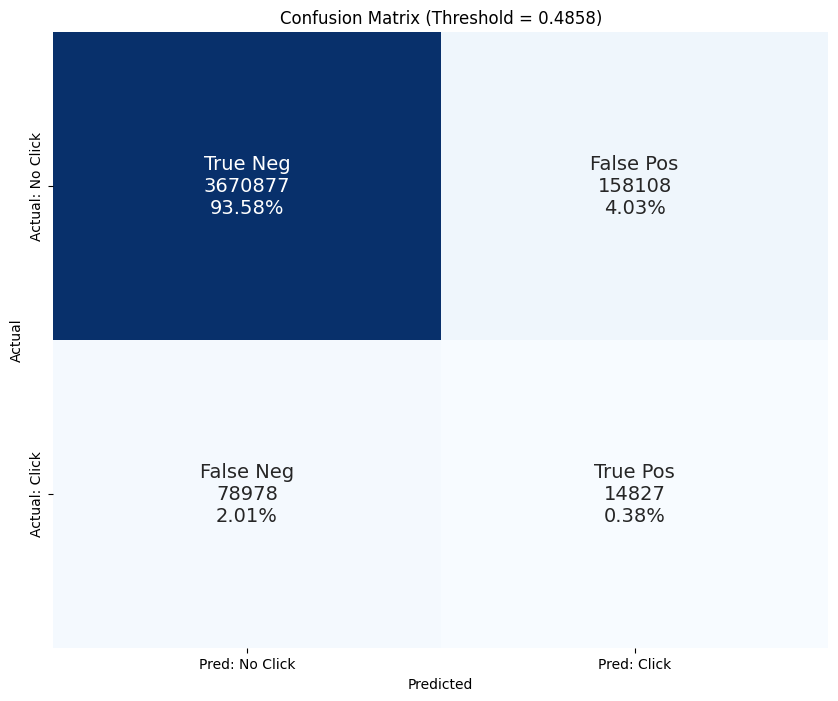

In [12]:
# 9. OPTIMIZED THRESHOLD EVALUATION & CONFUSION MATRIX
# ============================================================================

# 1. Find the Optimal Threshold (Maximizing F1 Score)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate F1 Score for each threshold
fscore = (2 * precision * recall) / (precision + recall + 1e-10)
ix = np.argmax(fscore)
best_thresh = thresholds[ix]

print(f"Best Threshold (Max F1): {best_thresh:.6f}")
print(f"Best F1 Score: {fscore[ix]:.4f}")

# 2. Re-Evaluate with New Threshold
y_pred_optimized = (y_pred_proba >= best_thresh).astype(int)

print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_optimized))

# 3. Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimized)

# Labels for the plot
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
             xticklabels=['Pred: No Click', 'Pred: Click'],
             yticklabels=['Actual: No Click', 'Actual: Click'],
             annot_kws={"size": 14})
plt.title(f'Confusion Matrix (Threshold = {best_thresh:.4f})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

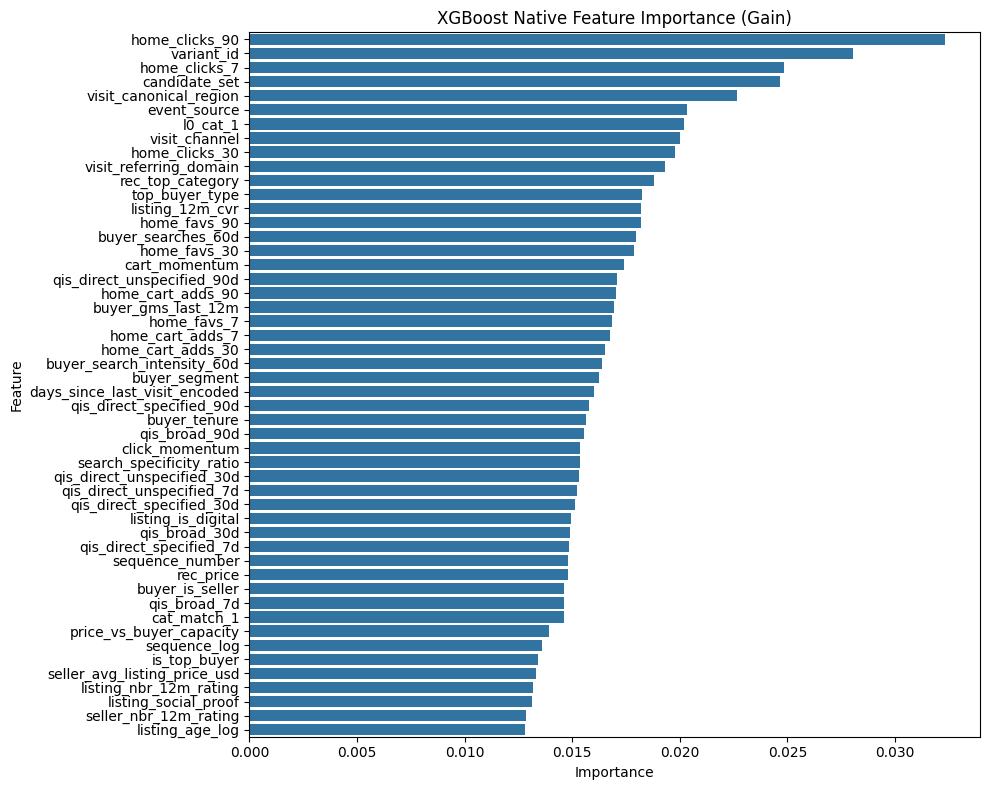

In [13]:
# 10. NATIVE FEATURE IMPORTANCE PLOT
# ============================================================================

importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False).head(50)

plt.figure(figsize=(15, 12))
sns.barplot(data=importance, x='Importance', y='Feature')
plt.title('XGBoost Native Feature Importance (Gain)')
plt.tight_layout()
plt.show()

In [14]:
importance.to_csv('feature_importances.csv')

In [16]:
# 11. SHAP ANALYSIS PREPARATION
# ============================================================================

# Performance optimization: Sample the data. 
shap_sample_size = 5000 
X_shap_sample = X_test.sample(n=shap_sample_size, random_state=42)
print(f"SHAP analysis using {shap_sample_size:,} samples from the test set.")

# This cell is intentionally left simple. The complex SHAP logic will go in the next cells.

SHAP analysis using 5,000 samples from the test set.


✓ SHAP values calculated using native XGBoost engine.


/opt/conda/envs/py312/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1406: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


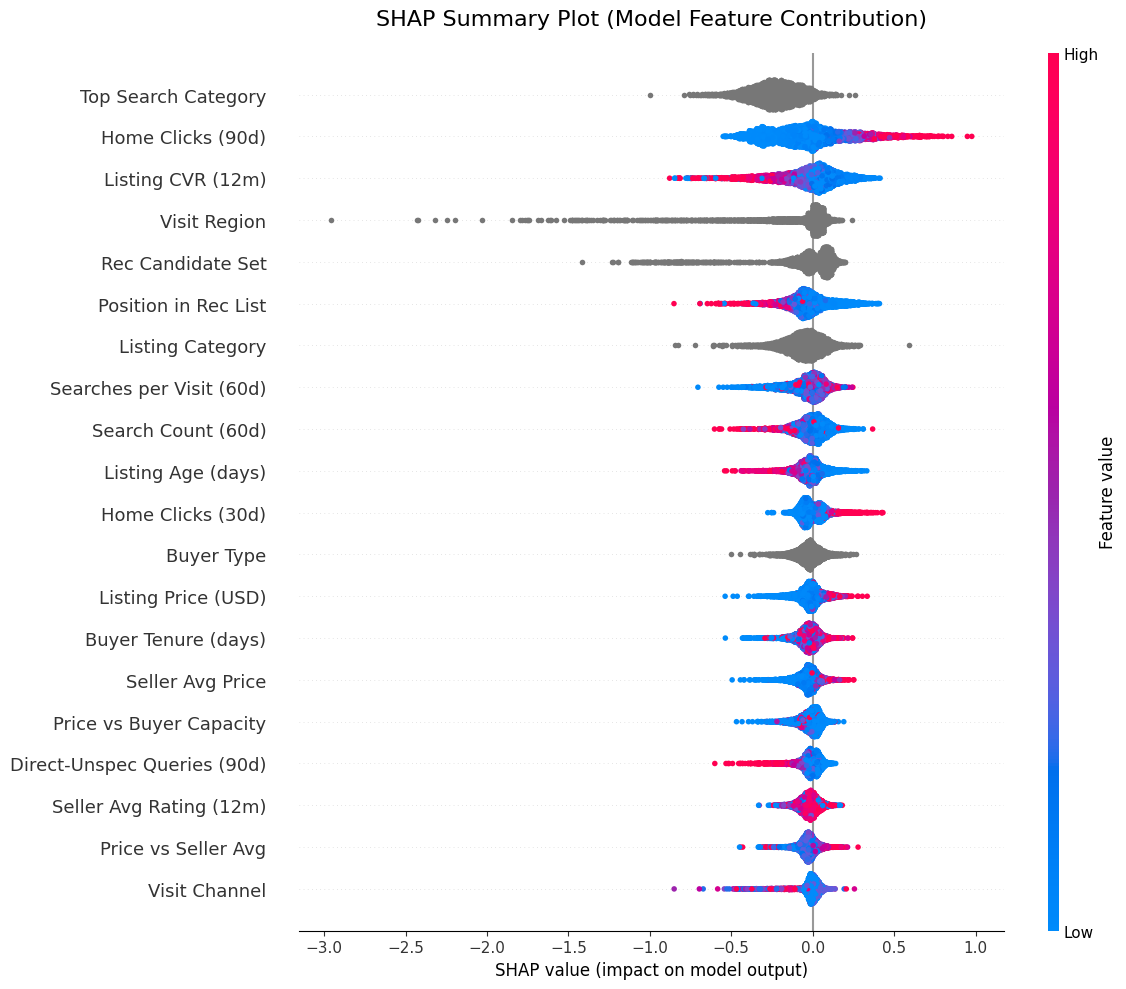


✓ SHAP plot saved as 'shap_summary_fixed.png'


In [17]:
# 1. Prepare Data & SHAP Explainer
# =============================================================================

# Create Native DMatrix for accurate SHAP calculation
dtest = xgb.DMatrix(X_shap_sample, enable_categorical=True)

# Calculate SHAP values using XGBoost's Native C++ Engine
booster = model.get_booster()
shap_contribs = booster.predict(dtest, pred_contribs=True)

# Separate SHAP Values from Bias Term
shap_values = shap_contribs[:, :-1]
base_values = shap_contribs[:, -1]

print("✓ SHAP values calculated using native XGBoost engine.")


# 2. Prepare Display Data (Fix Grey Dots)
# =============================================================================

X_display = X_shap_sample.copy()

# Define categorical features to be greyed out in the plot (by setting values to NaN)
categorical_to_grey = [
    'l0_cat_1', 'l0_cat_2', 'l0_cat_3', 'candidate_set', 
    'visit_canonical_region', 'rec_top_category', 
    'visit_referring_domain', 'top_buyer_type'
]

# Process data types for correct SHAP coloring
for col in X_display.columns:
    if col in categorical_to_grey:
        X_display[col] = np.nan
    elif X_display[col].dtype.name in ['category', 'object']:
        X_display[col] = X_display[col].cat.codes.astype('float32') if X_display[col].dtype.name == 'category' else pd.Categorical(X_display[col]).codes.astype('float32')
    else:
        # Handle numerical columns, converting to float and fixing Inf/NaN
        X_display[col] = pd.to_numeric(X_display[col], errors='coerce').astype('float32')
        X_display[col] = X_display[col].replace([np.inf, -np.inf], np.nan)
        X_display[col] = X_display[col].fillna(0)


# 3. Create Readable Feature Names
# =============================================================================

# Map technical column names to human-readable labels
feature_name_mapping = {
    # Categorical features
    'l0_cat_1': 'Top Search Category',
    'l0_cat_2': '2nd Search Category',
    'l0_cat_3': '3rd Search Category',
    'candidate_set': 'Rec Candidate Set',
    'visit_canonical_region': 'Visit Region',
    'rec_top_category': 'Listing Category',
    'visit_referring_domain': 'Referral Domain',
    'top_buyer_type': 'Buyer Type',
    'visit_channel': 'Visit Channel',
    'buyer_segment': 'Buyer Segment',
    'seller_tier_new': 'Seller Tier',
    'event_source': 'Platform',
    
    # Position & context
    'sequence_number': 'Position in Rec List',
    'sequence_log': 'Position (log)',
    'days_since_last_visit_encoded': 'Days Since Last Visit',
    
    # Listing attributes
    'listing_age': 'Listing Age (days)',
    'listing_age_log': 'Listing Age (log)',
    'listing_quality_score': 'Listing Quality Score',
    'listing_is_digital': 'Is Digital Listing',
    'listing_avg_12m_rating': 'Listing Avg Rating (12m)',
    'listing_nbr_12m_rating': 'Listing # Ratings (12m)',
    'listing_12m_cvr': 'Listing CVR (12m)',
    'listing_is_ad_eligible': 'Listing Ad-Eligible',
    'listing_social_proof': 'Listing Social Proof',
    
    # Price features
    'rec_price': 'Listing Price (USD)',
    'seller_avg_listing_price_usd': 'Seller Avg Price',
    'price_ratio_seller': 'Price vs Seller Avg',
    'price_vs_buyer_capacity': 'Price vs Buyer Capacity',
    
    # Seller attributes
    'seller_shop_open_tenure': 'Seller Tenure (days)',
    'seller_tenure_log': 'Seller Tenure (log)',
    'seller_12m_gms_percentile': 'Seller GMS %ile (12m)',
    'seller_avg_12m_rating': 'Seller Avg Rating (12m)',
    'seller_nbr_12m_rating': 'Seller # Ratings (12m)',
    'seller_social_proof': 'Seller Social Proof',
    
    # Buyer attributes
    'buyer_tenure': 'Buyer Tenure (days)',
    'buyer_is_seller': 'Buyer is Seller',
    'buyer_is_admin': 'Buyer is Admin',
    'buyer_gms_last_12m': 'Buyer GMS (12m)',
    'is_top_buyer': 'Is Top Buyer',
    
    # Buyer search behavior
    'buyer_searches_60d': 'Search Count (60d)',
    'buyer_search_intensity_60d': 'Searches per Visit (60d)',
    'search_specificity_ratio': 'Search Specificity Ratio',
    
    # Home engagement - 90 day
    'home_clicks_90': 'Home Clicks (90d)',
    'home_favs_90': 'Home Favorites (90d)',
    'home_cart_adds_90': 'Home Cart Adds (90d)',
    
    # Home engagement - 30 day
    'home_clicks_30': 'Home Clicks (30d)',
    'home_favs_30': 'Home Favorites (30d)',
    'home_cart_adds_30': 'Home Cart Adds (30d)',
    
    # Home engagement - 7 day
    'home_clicks_7': 'Home Clicks (7d)',
    'home_favs_7': 'Home Favorites (7d)',
    'home_cart_adds_7': 'Home Cart Adds (7d)',
    
    # Momentum features
    'click_momentum': 'Click Momentum (7d/30d)',
    'cart_momentum': 'Cart Momentum (7d/30d)',
    
    # Query Intent Specificity - 90 day
    'qis_broad_90d': 'Broad Queries (90d)',
    'qis_direct_unspecified_90d': 'Direct-Unspec Queries (90d)',
    'qis_direct_specified_90d': 'Direct-Spec Queries (90d)',
    
    # Query Intent Specificity - 30 day
    'qis_broad_30d': 'Broad Queries (30d)',
    'qis_direct_unspecified_30d': 'Direct-Unspec Queries (30d)',
    'qis_direct_specified_30d': 'Direct-Spec Queries (30d)',
    
    # Query Intent Specificity - 7 day
    'qis_broad_7d': 'Broad Queries (7d)',
    'qis_direct_unspecified_7d': 'Direct-Unspec Queries (7d)',
    'qis_direct_specified_7d': 'Direct-Spec Queries (7d)',
    
    # Category match features
    'cat_match_1': 'Matches Top Search Cat',
    'cat_match_2': 'Matches 2nd Search Cat',
    'cat_match_3': 'Matches 3rd Search Cat',
}

readable_feature_names = [
    feature_name_mapping.get(col, col) for col in X_shap_sample.columns
]


# 4. Generate SHAP Plot
# =============================================================================

explanation = shap.Explanation(
    values=shap_values,
    base_values=base_values,
    data=X_display.values, 
    feature_names=readable_feature_names 
)

plt.figure(figsize=(12, 10))
shap.summary_plot(
    explanation, 
    X_display, 
    show=False, 
    max_display=30, # Display top 20 features
    plot_size=(12, 10)
)
plt.title("SHAP Summary Plot (Model Feature Contribution)", fontsize=16, pad=20)
plt.xlabel("SHAP value (impact on model output)", fontsize=12)
plt.tight_layout()
# plt.savefig('shap_summary_fixed.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ SHAP plot saved as 'shap_summary_fixed.png'")

In [ ]:

# get_ipython().system('jupyter nbconvert MULE_SQ_v4.ipynb --to html')
get_ipython().system('jupyter nbconvert --to script MULE_SQ_v4.ipynb')


<Axes: xlabel='buyer_searches_60d', ylabel='buyer_search_intensity_60d'>

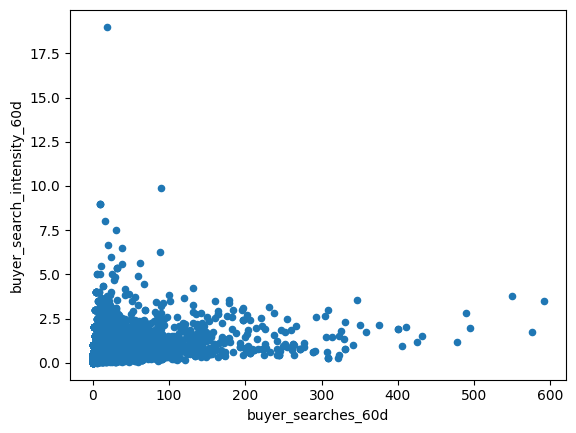

In [41]:
X_shap_sample.plot.scatter(x='buyer_searches_60d',y = 'buyer_search_intensity_60d')